# CXC SAP Multidimensional Poverty Index Submission
Our main objective is to come up with a weight for all the indicators in order to rank each country on a poverty index

In [632]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler

In [633]:
raw_data = pd.read_csv("Raw Data/SAP Datasets.csv")
raw_data.head()

Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                                      Indicator Name  \
0  Access to clean fuels and technologies for coo...   
1  Access to clean fuels and technologies for coo...   
2  Access to clean fuels and technologies for coo...   
3  Access to clean fuels and technologies for coo...   
4  Access to clean fuels and technologies for coo...   

                                  Topic short description  \
0  Environment: Energy production & use               NaN   
1  Environment: Energy production & use               NaN   
2  Environment: Energy production & use               NaN   
3  Environment: Energy production & use               NaN   
4  Environment: Energy production & use               NaN   

                                    long description  Indicator Code  \
0  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.ZS   
1  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.ZS   
2  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.ZS   
3  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.ZS   
4  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.ZS   

  Unit of measure       2000       2001  ...       2014       2015       2016  \
0               0        NaN        NaN  ...        NaN        NaN        NaN   
1               0  11.525904  11.850593  ...  17.401410  17.911234  18.463874   
2               0   5.500000   6.600000  ...  26.100000  27.600000  28.800000   
3               0   4.999422   5.138647  ...   9.111906  10.084891  11.282436   
4               0  40.900000  41.350000  ...  46.600000  47.300000  47.800000   

        2017       2018       2019       2020       2021       2022  2023  
0        NaN        NaN        NaN        NaN        NaN        NaN   NaN  
1  18.924037  19.437054  20.026254  20.647969  21.165877  21.863139   NaN  
2  30.300000  31.400000  32.600000  33.800000  34.900000  36.100000   NaN  
3  12.793263  14.663583  16.652106  18.714140  20.671958  22.319404   NaN  
4  48.300000  48.600000  49.000000  49.700000  49.800000  50.000000   NaN  

[5 rows x 32 columns]

# Data Cleaning and Preliminary Analysis

Our goal was to clean the data so that we could conduct Principle Component Analysis on the data. One main issue was there was too many years of data to go through. Part of the process was identifying what year we could remove in order to simplify the dataset:

In [634]:

data_sorted = raw_data.sort_values(by="Country Name")
data_sorted = data_sorted.drop(["Indicator Name", "Topic", "short description", "long description", "Unit of measure"], axis=1)

#Calculates coefficient of variance for 2000-2023
def coeff_var_full(row):
    if (row["mean (2000-2022)"] == 0):
        return np.nan
    
    return (row["stdev (2000-2022)"] / abs(row["mean (2000-2022)"])) * 100

#Calculates coefficient of variance for 2013-2023
def coeff_var_10yrs(row):
    if (row["mean (2013-2022)"] == 0):
        return np.nan
    
    return (row["stdev (2013-2022)"] / abs(row["mean (2013-2022)"])) * 100

#Calculating the variance in the dataset from 2000-2023
data_sorted["mean (2000-2022)"] = data_sorted.loc[:, '2000':'2022'].mean(axis=1)
data_sorted["stdev (2000-2022)"] = data_sorted.loc[:, '2000':'2022'].std(axis=1)
data_sorted["CV (2000-2023)"] = data_sorted.apply(coeff_var_full,axis=1)

#Calculation the variance in the dataset from 2013 to 2022
data_sorted["mean (2013-2022)"] = data_sorted.loc[:, '2013':'2022'].mean(axis=1)
data_sorted["stdev (2013-2022)"] = data_sorted.loc[:, '2013':'2022'].std(axis=1)
data_sorted["CV (2013-2022)"] = data_sorted.apply(coeff_var_10yrs,axis=1)

# Number of values with a variance exceeding 50% for 2000-2023 and 2013-2022
data_sorted.head()


Country Name Country Code        Indicator Code       2000       2001  \
18885  Afghanistan          AFG     SE.ENR.SECO.FM.ZS        NaN   0.000000   
267    Afghanistan          AFG     EG.CFT.ACCS.RU.ZS   0.800000   1.000000   
21811  Afghanistan          AFG     SL.EMP.WORK.MA.ZS   8.879139   8.856137   
21279  Afghanistan          AFG     SP.URB.TOTL.IN.ZS  22.078000  22.169000   
15160  Afghanistan          AFG  SE.ADT.1524.LT.FM.ZS        NaN        NaN   

            2002       2003       2004       2005       2006  ...       2020  \
18885        NaN   0.350760   0.209610   0.326420   0.363540  ...        NaN   
267     1.300000   1.600000   1.900000   2.400000   3.000000  ...  16.400000   
21811   9.108199   9.323011   9.461196   9.673263   9.835655  ...  17.516361   
21279  22.261000  22.353000  22.500000  22.703000  22.907000  ...  26.026000   
15160        NaN        NaN        NaN        NaN        NaN  ...        NaN   

           2021       2022    2023  mean (2000-2022)  stdev (2000-2022)  \
18885       NaN        NaN     NaN          0.442298           0.158228   
267    17.40000  18.500000     NaN          8.043478           5.897135   
21811  19.59946  18.841205     NaN         12.883136           3.510048   
21279  26.31400  26.616000  26.933         24.044130           1.426702   
15160   0.58382        NaN     NaN          0.487704           0.114982   

       CV (2000-2023)  mean (2013-2022)  stdev (2013-2022)  CV (2013-2022)  
18885       35.774182          0.562873           0.008324        1.478824  
267         73.315737         13.910000           3.139515       22.570203  
21811       27.245292         16.366153           2.054469       12.553160  
21279        5.933682         25.423800           0.750823        2.953227  
15160       23.576141          0.472072           0.158036       33.477114  

[5 rows x 33 columns]

From this data, we can see that the number of entries with a variance of over 50% is larger when using a larger time scale. And by reducing the span down to 10 years, we can see that the number of entries with variance over 50% gets reduced by more than 50%.

Our first attempt to sort out the data was by removing the indicators that were missing too much information.

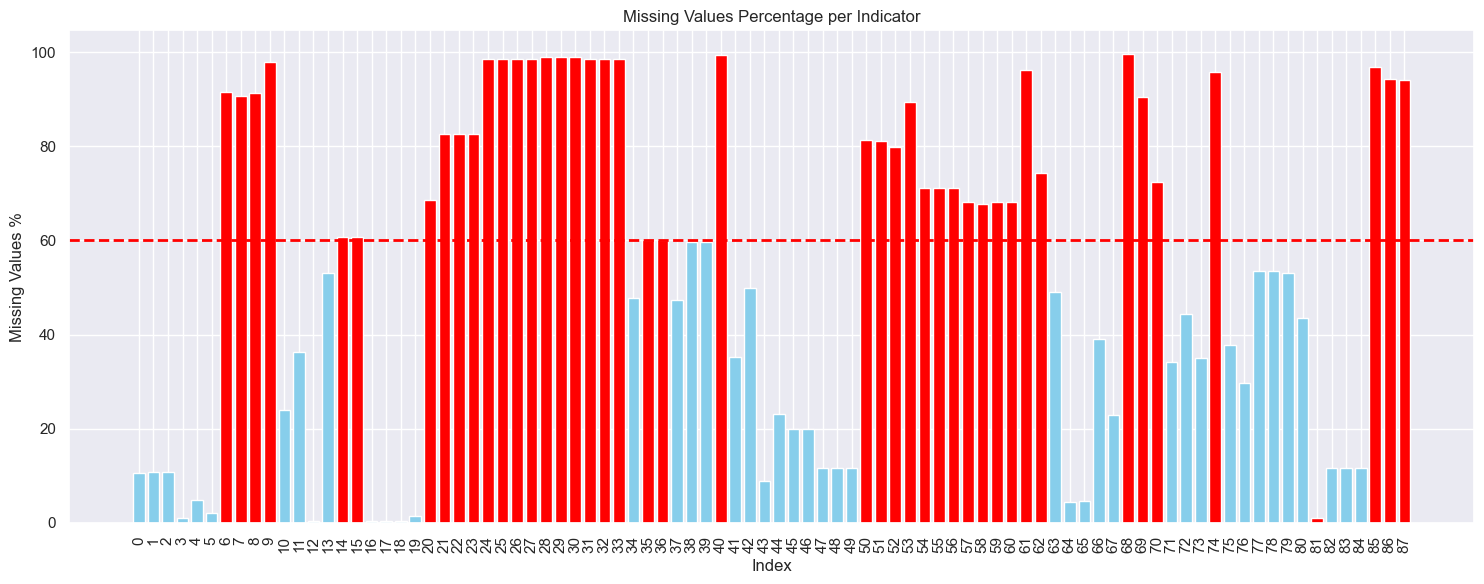

Country Code                                     Indicator Name  \
0          ABW  Access to clean fuels and technologies for coo...   
1          AFE  Access to clean fuels and technologies for coo...   
2          AFG  Access to clean fuels and technologies for coo...   
3          AFW  Access to clean fuels and technologies for coo...   
4          AGO  Access to clean fuels and technologies for coo...   

   Indicator Code       2013       2014       2015       2016       2017  \
0  EG.CFT.ACCS.ZS        NaN        NaN        NaN        NaN        NaN   
1  EG.CFT.ACCS.ZS  16.877313  17.401410  17.911234  18.463874  18.924037   
2  EG.CFT.ACCS.ZS  24.500000  26.100000  27.600000  28.800000  30.300000   
3  EG.CFT.ACCS.ZS   8.400273   9.111906  10.084891  11.282436  12.793263   
4  EG.CFT.ACCS.ZS  45.950000  46.600000  47.300000  47.800000  48.300000   

        2018       2019       2020       2021       2022  
0        NaN        NaN        NaN        NaN        NaN  
1  19.437054  20.026254  20.647969  21.165877  21.863139  
2  31.400000  32.600000  33.800000  34.900000  36.100000  
3  14.663583  16.652106  18.714140  20.671958  22.319404  
4  48.600000  49.000000  49.700000  49.800000  50.000000

In [635]:
# Deletion 1
# Deletion of years 2000 - 2012 and 2023
dropped_years = [str(dropped_year) for dropped_year in range(2000, 2013)] + ["2023"]
df = raw_data.drop(dropped_years, axis=1)

# Groupby Indicator Name with the count of their missing values. 
year_columns = [str(year) for year in range(2013, 2023)]
df = df.groupby('Indicator Name')[year_columns].apply(lambda x: x.isna().sum()).reset_index()

# Manual changing data values for Population Total due to an error
df.loc[68, df.columns != "Indicator Name"] = 265

#Deletion 2
# Creation of Missing Values % column which represent the percentage of missing values per indicator
df['Missing Values %'] = (df[year_columns].sum(axis=1)/(266*10)) * 100

# Configurations for plotting the bar chart of missing values percentage per indicator
plt.figure(figsize=(15, 6))  

x = np.arange(len(df)) 
threshold = 60 # Cut-off threshold

exception_indicators = [61, 62, 68, 81] # Manually removing redundant indicators

red_indices = df[df['Missing Values %'] > threshold].index.tolist()
all_red_indices = set(red_indices + exception_indicators) #Addding both redundant and >60% missing values indicators

# Assign colors: Red if in all_red_indices, otherwise skyblue
bar_colors = ['red' if i in all_red_indices else 'skyblue' for i in df.index]

# Adding more details to the chart
plt.bar(x, df['Missing Values %'], color=bar_colors)
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold}%)')
plt.xlabel('Index')
plt.ylabel('Missing Values %')
plt.title('Missing Values Percentage per Indicator')
plt.xticks(x, df.index, rotation=90)  
plt.tight_layout() 
plt.show()

# Create a list of indicators to be removed 
corresponding_values = df.loc[list(all_red_indices), 'Indicator Name'].tolist()

#Creating a new dataset removing desired indicators and years.
df_copy = pd.read_csv("Raw Data/SAP Datasets.csv")

headers = ["Country Code", "Indicator Name", "Indicator Code"] + year_columns
df_copy = df_copy[headers]
indices_to_remove = df_copy[df_copy['Indicator Name'].isin(corresponding_values)].index
df_copy = df_copy.drop(indices_to_remove)

#Deletion 3
# Removing Country Name found to not be classified
df_copy = df_copy[df_copy['Country Code'] != 'INX']

df_copy.head()

The problem with this approach was when it came to do PCA, on the reduced list of indicators. The level of variance was too much. Not only this, but some of the indicators that were removed were key indicators that are used in other MPIs. Therefore we decided to work with the full set of indicators and only to filter them out after the PCA was conducted.

In [636]:
df_copy = pd.read_csv("Raw Data/SAP Datasets.csv")
df_copy = df_copy[df_copy['Country Code'] != 'INX']

df_copy["mean"] = data_sorted.loc[:, "2013":"2022"].mean(axis=1)

#Remove the rest of the year columns and leaving only the aggregate of the 10 years
data_with_mean = df_copy.dropna(subset=["mean"])
data_with_mean = data_with_mean[["Country Code", "Indicator Code", "mean"]]

print("\nData with only the Country Code, Indicator, and mean:\n")
data_with_mean.head()


Data with only the Country Code, Indicator, and mean:



Country Code  Indicator Code       mean
1          AFE  EG.CFT.ACCS.ZS  19.271816
2          AFG  EG.CFT.ACCS.ZS  30.610000
3          AFW  EG.CFT.ACCS.ZS  14.469396
4          AGO  EG.CFT.ACCS.ZS  48.305000
5          ALB  EG.CFT.ACCS.ZS  79.680000

Now that we have the aggregate of all the years in the form of a mean. We reformatted the data so that the each row was a unique country, and the rest of the columns were transposed. This means that each column will be an indicator.

In [637]:
#Separate dataframe containing only country names for iteration later on
country = data_with_mean[["Country Code"]]
country = country.drop_duplicates("Country Code", keep="first")
country = country.reset_index()

#creating the list of indicators to put into a new empty dataframe
indicator_columns = data_with_mean.drop_duplicates("Indicator Code", keep="first")
indicator_columns = indicator_columns["Indicator Code"].tolist()

#Initialize new dataframe
new_data_set = pd.DataFrame(columns=["Country Code", *indicator_columns])

#iterates through the rows and columns to place all the indicator values accordingly
# each row represents a country, and each column is an indicator
# the mean value is placed into its respective country row and indicator column
# the result is a table with 265 rows, one for each country, and 44 columns, for each indicator
for i in range(len(country)):
    country_name = str(country.at[i, "Country Code"])
    new_data_set.at[i, "Country Code"] = country_name
    for column in new_data_set.iloc[:, 1:]:
        index_value = data_with_mean.loc[(data_with_mean["Country Code"] == country_name)&
                               (data_with_mean["Indicator Code"] == column)]
        index_value = index_value[["mean"]].reset_index()
        if index_value.empty:
            continue
        new_data_set.at[i, column] = index_value.at[0, "mean"]

#fill in empty cells with 0 (see getting_mean for getting list of zeroed countries)
new_data_set.head()


Country Code EG.CFT.ACCS.ZS EG.CFT.ACCS.RU.ZS EG.CFT.ACCS.UR.ZS  \
0          AFE      19.271816          7.787618         39.270685   
1          AFG          30.61             13.91             81.48   
2          AFW      14.469396          3.762705         28.676408   
3          AGO         48.305              7.98             76.98   
4          ALB          79.68              61.9             92.53   

  EG.ELC.ACCS.ZS EG.ELC.ACCS.RU.ZS EG.ELC.ACCS.UR.ZS per_si_allsi.adq_pop_tot  \
0      40.699799         25.651345         70.921178                      NaN   
1          89.62             87.01             97.56                      NaN   
2      50.494766         24.886825         82.024115                      NaN   
3          43.17              5.55             68.32                51.766544   
4          99.97             99.91             99.99               300.556065   

  per_allsp.adq_pop_tot per_sa_allsa.adq_pop_tot  ... SL.UEM.BASC.ZS  \
0                   NaN                      NaN  ...            NaN   
1                   NaN                      NaN  ...           9.38   
2                   NaN                      NaN  ...       4.739257   
3             51.766544                      NaN  ...      14.073333   
4            264.770815                77.299548  ...       12.06075   

  SL.UEM.INTM.ZS SL.UEM.TOTL.NE.ZS SP.URB.TOTL.IN.ZS SL.EMP.WORK.FE.ZS  \
0            NaN               NaN         35.625343         19.079166   
1         12.056             9.122           25.4238           6.14692   
2       8.999405          5.375013         46.326954          12.89241   
3      24.544667         13.958333           65.1224         25.615828   
4      16.974375         14.120222           59.7476         45.080572   

  SL.EMP.WORK.MA.ZS SL.EMP.WORK.ZS SP.DYN.WFRT SP.M15.2024.FE.ZS  \
0         30.335839      25.063857         NaN               NaN   
1         16.366153      14.518658         4.4               8.8   
2         21.854736      17.853646    4.466846               NaN   
3         44.944986      35.377714         5.2               7.9   
4         42.781862      43.795599         1.6               1.4   

  SP.M18.2024.FE.ZS  
0               NaN  
1              34.8  
2               NaN  
3              30.3  
4              11.8  

[5 rows x 89 columns]

In order for the PCA function to work properly, all NaN inputs will be zeroed. We will note down the countries with NaN indicators accordingly. We will also set the country column as the index.

In [638]:
new_data_set = new_data_set.fillna(0)
new_data_set = new_data_set.set_index(new_data_set.columns[0])
new_data_set.head()

/var/folders/f4/jj9s9qy16sl2w2ltwtbkxhs80000gn/T/ipykernel_50616/299373377.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_data_set = new_data_set.fillna(0)


EG.CFT.ACCS.ZS  EG.CFT.ACCS.RU.ZS  EG.CFT.ACCS.UR.ZS  \
Country Code                                                         
AFE                19.271816           7.787618          39.270685   
AFG                30.610000          13.910000          81.480000   
AFW                14.469396           3.762705          28.676408   
AGO                48.305000           7.980000          76.980000   
ALB                79.680000          61.900000          92.530000   

              EG.ELC.ACCS.ZS  EG.ELC.ACCS.RU.ZS  EG.ELC.ACCS.UR.ZS  \
Country Code                                                         
AFE                40.699799          25.651345          70.921178   
AFG                89.620000          87.010000          97.560000   
AFW                50.494766          24.886825          82.024115   
AGO                43.170000           5.550000          68.320000   
ALB                99.970000          99.910000          99.990000   

              per_si_allsi.adq_pop_tot  per_allsp.adq_pop_tot  \
Country Code                                                    
AFE                           0.000000               0.000000   
AFG                           0.000000               0.000000   
AFW                           0.000000               0.000000   
AGO                          51.766544              51.766544   
ALB                         300.556065             264.770815   

              per_sa_allsa.adq_pop_tot  per_lm_alllm.adq_pop_tot  ...  \
Country Code                                                      ...   
AFE                           0.000000                       0.0  ...   
AFG                           0.000000                       0.0  ...   
AFW                           0.000000                       0.0  ...   
AGO                           0.000000                       0.0  ...   
ALB                          77.299548                       0.0  ...   

              SL.UEM.BASC.ZS  SL.UEM.INTM.ZS  SL.UEM.TOTL.NE.ZS  \
Country Code                                                      
AFE                 0.000000        0.000000           0.000000   
AFG                 9.380000       12.056000           9.122000   
AFW                 4.739257        8.999405           5.375013   
AGO                14.073333       24.544667          13.958333   
ALB                12.060750       16.974375          14.120222   

              SP.URB.TOTL.IN.ZS  SL.EMP.WORK.FE.ZS  SL.EMP.WORK.MA.ZS  \
Country Code                                                            
AFE                   35.625343          19.079166          30.335839   
AFG                   25.423800           6.146920          16.366153   
AFW                   46.326954          12.892410          21.854736   
AGO                   65.122400          25.615828          44.944986   
ALB                   59.747600          45.080572          42.781862   

              SL.EMP.WORK.ZS  SP.DYN.WFRT  SP.M15.2024.FE.ZS  \
Country Code                                                   
AFE                25.063857     0.000000                0.0   
AFG                14.518658     4.400000                8.8   
AFW                17.853646     4.466846                0.0   
AGO                35.377714     5.200000                7.9   
ALB                43.795599     1.600000                1.4   

              SP.M18.2024.FE.ZS  
Country Code                     
AFE                         0.0  
AFG                        34.8  
AFW                         0.0  
AGO                        30.3  
ALB                        11.8  

[5 rows x 88 columns]

# Principal Component Analysis

Now that the data has been cleaned and formatted correctly, we will perform Principal Component Analysis (PCA) on the data in order to help us determine the weight that each indicator should have. We will use the respective loading value from each indicator to also remove any indicator that does not contribute to a lot of variance.

In [639]:
scaled_dataset = preprocessing.scale(new_data_set)

pca = PCA()
pca.fit(scaled_dataset)
pca_data = pca.transform(scaled_dataset)
per_var = np.round(pca.explained_variance_ratio_* 100, decimals = 1)
labels = ["PC" + str(x) for x in range(1, len(per_var) + 1)]

plt.figure(figsize=(20,6))
plt.bar(x = range(1, len(per_var) + 1), height = per_var, tick_label = labels)
plt.ylabel("Percentage of Explained Variance")
plt.xticks(rotation=45)
plt.xlabel("Principal Component")
plt.title("Scree Plot")
plt.show()

/Users/samshin/Documents/Projects/CXC poverty index/project_env/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


We can also plot the cumulative sum of each Principal Component to determine a cutoff point.

In [640]:
variance = np.cumsum(pca.explained_variance_ratio_ * 100)

plt.figure(figsize=(20, 10))
plt.plot(np.arange(88), variance, marker ='o', linestyle='-', color='b', label='cumulative sum of variance')
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative Sum of Variance")
plt.title("Cumulative Sum of the Variance")
plt.show()

From this graph, we can use the first 20 Principal Components to come to an analysis that accounts for 80% of the variance. taking any further leads to a diminishing rate of accounting for the variance. We can now take the loading scores of each indicator based off the first 20 Principal Components.

We can get a rough visualisation of how each country ranks based on PC1 and PC2. From observation, we can see that the information lines up to a certain extent. We can also start to remove indicators whose contribution to the variance is less than 1.

In [641]:
pca_df = pd.DataFrame(pca_data, index = new_data_set.T.columns.tolist(), columns = labels)
plt.figure(figsize=(20, 10))
plt.scatter(pca_df.PC2 , pca_df.PC1)
plt.xlabel("PC2 - {0}%".format(per_var[0]))
plt.ylabel("PC1 - {0}%".format(per_var[1]))

for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC2.loc[sample], pca_df.PC1.loc[sample]), fontsize= 8)
plt.show()

In [644]:
loading_scores = pd.DataFrame(pca.components_, columns=new_data_set.columns)
loading_scores = loading_scores.T
loading_scores.columns = ["PC" + str(x) for x in range(1,89)]
loading_scores = loading_scores.loc[:, "PC1":"PC20"]
loading_scores["Mean Loading Score"] = loading_scores.mean(axis=1)
loading_scores["Mean Loading Score"] = loading_scores["Mean Loading Score"] * 100
loading_scores = loading_scores.drop(loading_scores.columns[0:20], axis=1)
loading_scores.index.name = "Indicator ID"
loading_scores = loading_scores.reset_index()

In [647]:
loading_scores = loading_scores[loading_scores["Mean Loading Score"] >= 1]
loading_scores = loading_scores.sort_values(by="Mean Loading Score", ascending=True).reset_index(drop=True)
loading_scores.head()

Indicator ID  Mean Loading Score
0        SL.UEM.BASC.ZS            1.034900
1        SE.PRM.UNER.ZS            1.169005
2        SL.UEM.ADVN.ZS            1.257262
3  SL.TLF.0714.SW.MA.ZS            1.328881
4        SE.XPD.PRIM.ZS            1.356903

One thing we notice about the data is that each indicator only accounts for at most 5% of the variance.

# Heatmap
Now we have a scatter plot of the rest of the indicators. From the plot, we noticed that there are still a lot of indicators that are grouped closely together. From this insight, we decided to plot a correlation heatmap of all the different indicators to see if we could further reduce the number of indicators on the plot

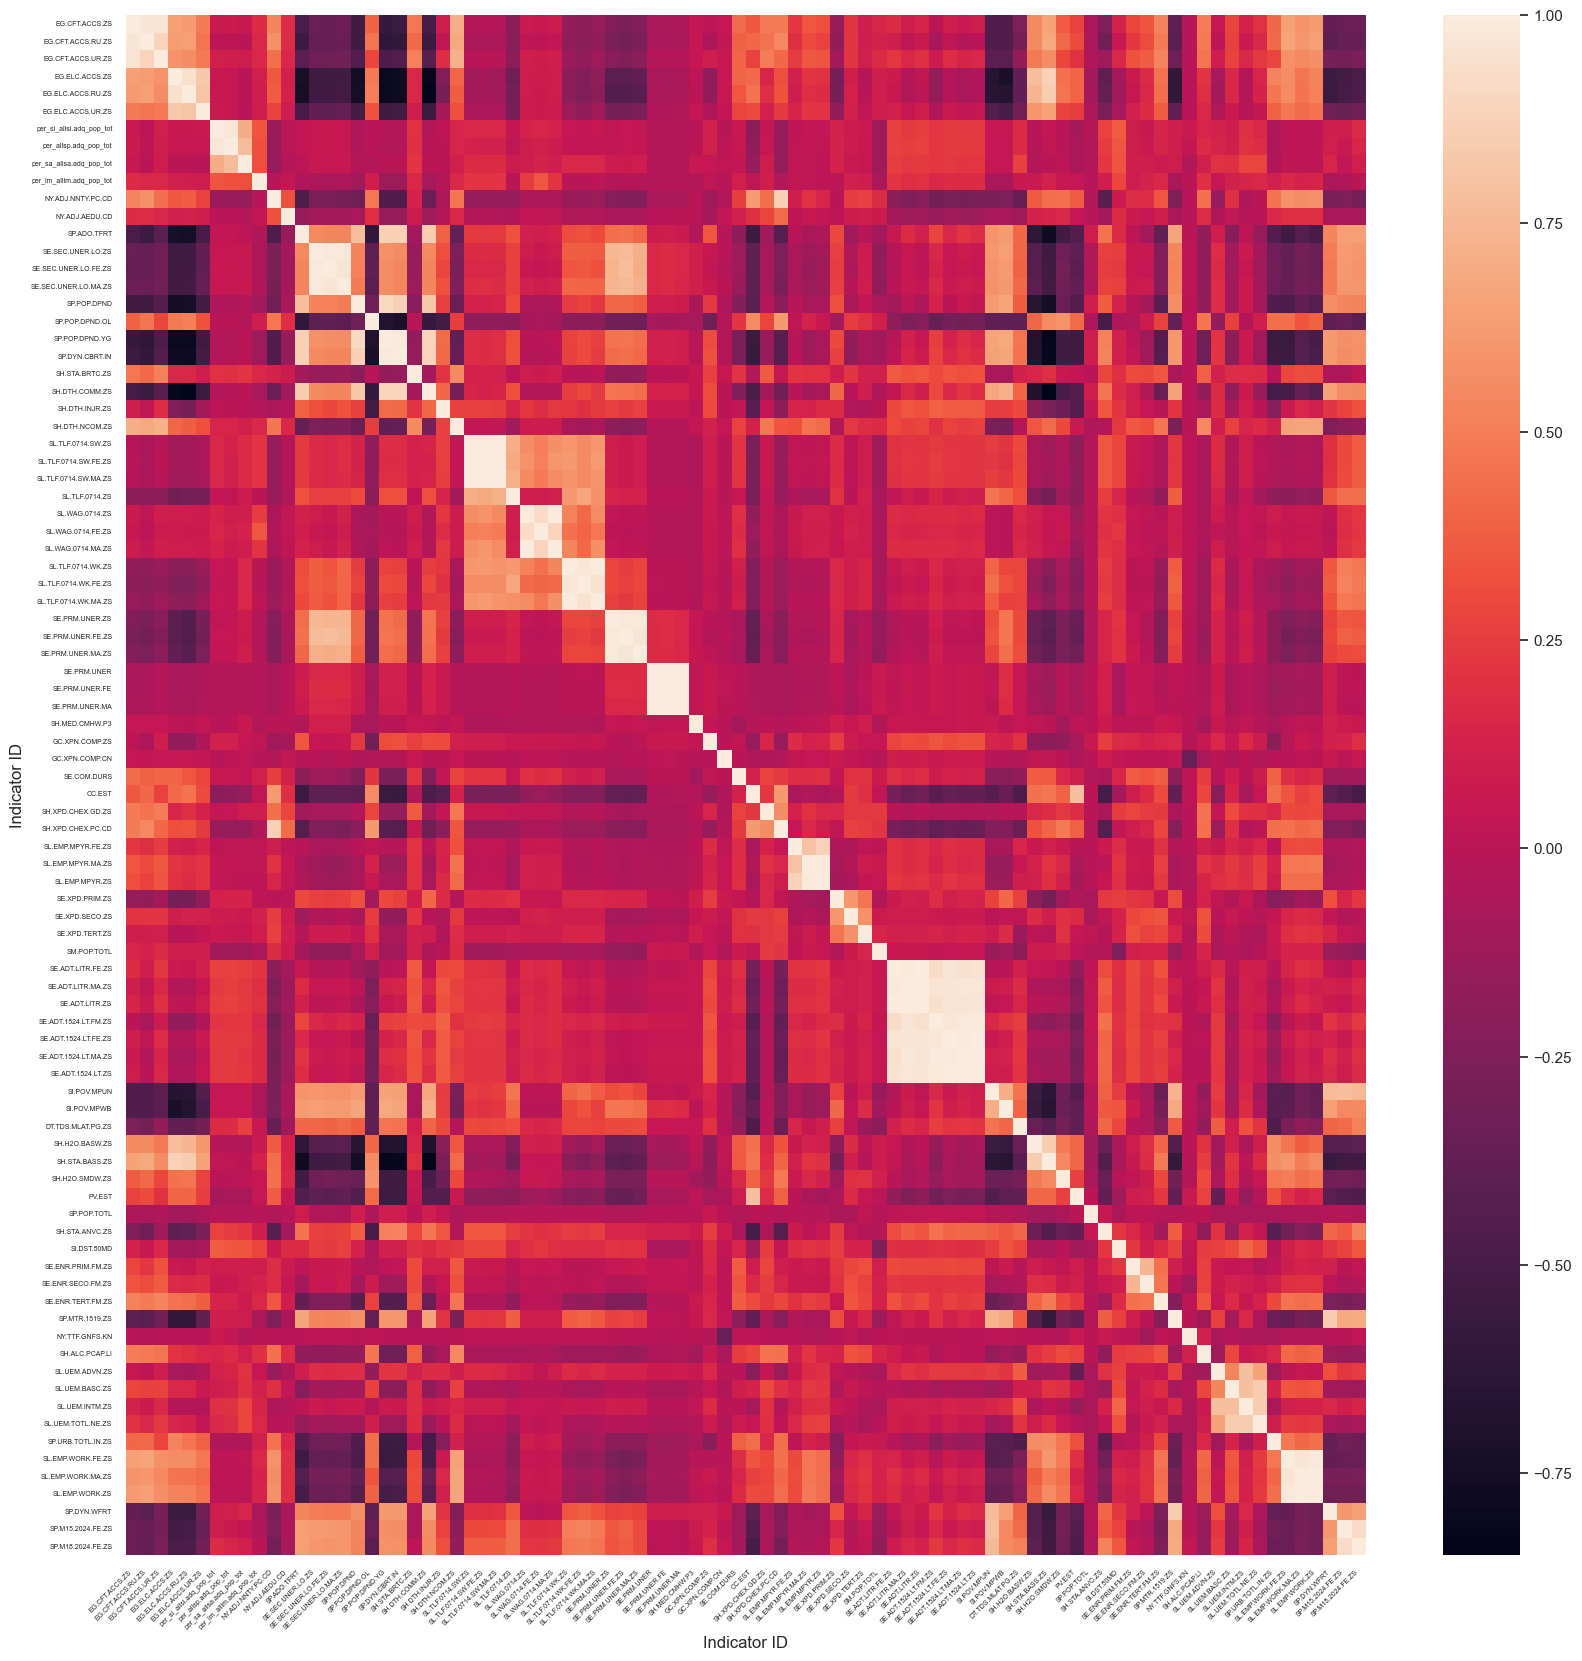

Indicator ID       EG.CFT.ACCS.ZS  EG.CFT.ACCS.RU.ZS  EG.CFT.ACCS.UR.ZS  \
Indicator ID                                                              
EG.CFT.ACCS.ZS           1.000000           0.967099           0.963116   
EG.CFT.ACCS.RU.ZS        0.967099           1.000000           0.884841   
EG.CFT.ACCS.UR.ZS        0.963116           0.884841           1.000000   
EG.ELC.ACCS.ZS           0.640147           0.629899           0.586923   
EG.ELC.ACCS.RU.ZS        0.619872           0.634955           0.560288   
...                           ...                ...                ...   
SL.EMP.WORK.MA.ZS        0.593824           0.599489           0.549014   
SL.EMP.WORK.ZS           0.623075           0.634857           0.568398   
SP.DYN.WFRT             -0.374297          -0.402846          -0.290530   
SP.M15.2024.FE.ZS       -0.347066          -0.357652          -0.298660   
SP.M18.2024.FE.ZS       -0.344529          -0.367810          -0.276270   

Indicator ID       EG.ELC.ACCS.ZS  EG.ELC.ACCS.RU.ZS  EG.ELC.ACCS.UR.ZS  \
Indicator ID                                                              
EG.CFT.ACCS.ZS           0.640147           0.619872           0.489375   
EG.CFT.ACCS.RU.ZS        0.629899           0.634955           0.461545   
EG.CFT.ACCS.UR.ZS        0.586923           0.560288           0.482893   
EG.ELC.ACCS.ZS           1.000000           0.948207           0.830467   
EG.ELC.ACCS.RU.ZS        0.948207           1.000000           0.805759   
...                           ...                ...                ...   
SL.EMP.WORK.MA.ZS        0.465466           0.456311           0.422701   
SL.EMP.WORK.ZS           0.517889           0.511374           0.454422   
SP.DYN.WFRT             -0.545295          -0.560411          -0.320584   
SP.M15.2024.FE.ZS       -0.516860          -0.511168          -0.352143   
SP.M18.2024.FE.ZS       -0.489425          -0.479400          -0.311869   

Indicator ID       per_si_allsi.adq_pop_tot  per_allsp.adq_pop_tot  \
Indicator ID                                                         
EG.CFT.ACCS.ZS                     0.067803               0.070016   
EG.CFT.ACCS.RU.ZS                  0.006468               0.011518   
EG.CFT.ACCS.UR.ZS                  0.107675               0.103685   
EG.ELC.ACCS.ZS                     0.057300               0.049609   
EG.ELC.ACCS.RU.ZS                  0.058686               0.048629   
...                                     ...                    ...   
SL.EMP.WORK.MA.ZS                  0.009651               0.009322   
SL.EMP.WORK.ZS                     0.008497               0.007282   
SP.DYN.WFRT                        0.095710               0.110319   
SP.M15.2024.FE.ZS                  0.090425               0.062198   
SP.M18.2024.FE.ZS                  0.173279               0.147477   

Indicator ID       per_sa_allsa.adq_pop_tot  per_lm_alllm.adq_pop_tot  ...  \
Indicator ID                                                           ...   
EG.CFT.ACCS.ZS                     0.060711                  0.172634  ...   
EG.CFT.ACCS.RU.ZS                  0.003799                  0.149153  ...   
EG.CFT.ACCS.UR.ZS                  0.090201                  0.159367  ...   
EG.ELC.ACCS.ZS                    -0.002435                  0.105312  ...   
EG.ELC.ACCS.RU.ZS                 -0.003333                  0.092209  ...   
...                                     ...                       ...  ...   
SL.EMP.WORK.MA.ZS                  0.017604                  0.130535  ...   
SL.EMP.WORK.ZS                     0.017555                  0.140638  ...   
SP.DYN.WFRT                        0.143662                 -0.071604  ...   
SP.M15.2024.FE.ZS                  0.028460                 -0.047138  ...   
SP.M18.2024.FE.ZS                  0.107412                  0.000957  ...   

Indicator ID       SL.UEM.BASC.ZS  SL.UEM.INTM.ZS  SL.UEM.TOTL.NE.ZS  \
Indicator ID                                      

In [648]:
correlation_df = new_data_set.corr(numeric_only=True)
plt.figure(figsize=(20,20))
dataplot = sns.heatmap(correlation_df)

plt.xticks(ticks=np.arange(len(correlation_df.columns)) + 0.5, labels=correlation_df.columns, rotation=45, ha="right", fontsize=5)
plt.yticks(ticks=np.arange(len(correlation_df.index)) + 0.5, labels=correlation_df.index, rotation=0, fontsize=5)
plt.show()
correlation_df

We notice that there are a lot of very strongly correlated variables. This makes sense if we were to look at literacy rate, for example, there are 7 categories, that separate literacy rate by different demographics. If the literacy rate for one demographic is low, we can expect similar results for the others as well.

From this information, we can now group together indicators which have strong correlations with each other and generalize them, to get a more significant weightage.

# Group the Indicators and Weighing Groups

In [649]:
grouped_indicators = pd.read_csv("Raw Data/Groupings.csv")

#Ensure both tables are sorted in alphabetical order
grouped_indicators = grouped_indicators.sort_values(by="Indicator ID", ascending = True)
loading_scores = loading_scores.sort_values(by="Indicator ID", ascending = True)

#Add the group numbers onto the loading_scores dataset
loading_scores["Group"] = grouped_indicators["Group No"]
loading_scores.sort_values(by="Group", ascending=True).head()

Indicator ID  Mean Loading Score  Group
0        SL.UEM.BASC.ZS            1.034900      1
2        SL.UEM.ADVN.ZS            1.257262      1
1        SE.PRM.UNER.ZS            1.169005      1
3  SL.TLF.0714.SW.MA.ZS            1.328881      2
4        SE.XPD.PRIM.ZS            1.356903      3

In [ ]:
loading_score_by_grp = pd.DataFrame(columns = ["Group", "Loading Score"])

loading_score_by_grp["Group"] = loading_scores.drop_duplicates("Group", keep="first")["Group"]
loading_score_by_grp = loading_score_by_grp.sort_values(by="Group", ascending= True).reset_index(drop=True)

#Getting the sum of the loading score from each indicator for each group
for i in range(len(loading_score_by_grp)):
    loading_score_by_grp.at[i, "Loading Score"] = loading_scores[loading_scores["Group"] == i + 1]["Mean Loading Score"].sum()

loading_score_by_grp.head()

Group Loading Score
0      1      3.567906
1      2      1.434559
2      3      3.267445
3      4      1.721765
4      5      3.593012

In [ ]:
sum = loading_score_by_grp["Loading Score"].sum()
loading_score_by_grp["Weight"] = np.nan


# Calculating the weightage for each group
for i in range(len(loading_score_by_grp)):
    loading_score_by_grp.at[i, "Weight"] = loading_score_by_grp.at[i, "Loading Score"] / sum * 100

loading_score_by_grp


Group Loading Score     Weight
0       1      3.567906   2.695144
1       2      1.434559   1.083645
2       3      3.267445   2.468181
3       4      1.721765   1.300596
4       5      3.593012   2.714109
5       6      1.867774   1.410889
6       7     23.984757  18.117739
7       8      17.28834  13.059362
8       9     20.741968  15.668183
9      10     39.915196  30.151362
10     11       9.70091   7.327927
11     12      5.299098   4.002862

Now we need to scale all the values for each country so that there is no big discrepancy when it comes to calculating the index. This way the highest value our index can get to is 1

In [ ]:
reference_data = loading_scores[["Indicator ID", "Group"]]
reference_data = reference_data.sort_values(by="Group", ascending=True).reset_index(drop=True)
dictionary = reference_data.set_index("Indicator ID")["Group"].to_dict()

#Scaling the measurements down so that the measurements are consistent
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(new_data_set), index=new_data_set.index, columns=new_data_set.columns)

#Getting the mean of all the indicators in the group and replacing them for each country
grouped_indicator_data = df_standardized.T
grouped_indicator_data["Group"] = grouped_indicator_data.index.map(dictionary)
grouped_indicator_data = grouped_indicator_data.groupby("Group").mean().T

grouped_indicator_data

Group             1.0       2.0       3.0       4.0       5.0       6.0   \
Country Code                                                               
AFG          -0.835471 -0.647093  0.393219  1.249305 -0.077520 -1.006395   
AFW          -0.013196 -0.647093 -1.039757 -1.202805  0.613216 -1.006395   
DZA          -0.705912  0.205058 -0.338924 -0.185702  0.014783  0.923815   
ASM           0.613201 -0.647093  1.714702  0.772612  0.021935  1.335754   
AND           0.845761 -0.647093  1.171547  0.602452 -1.693091  1.523844   
...                ...       ...       ...       ...       ...       ...   
PRI          -0.835471 -0.647093  0.541591 -1.874107 -1.693091 -0.061286   
KNA          -0.835471 -0.647093  3.122963  1.709963 -0.010147  1.670419   
VCT          -0.835471  3.956689 -0.233382  1.351107  1.971087 -1.006395   
URY          -0.838320 -0.647093  0.261609  1.019953 -0.073099 -0.031714   
IDA          -1.817915 -0.647093 -1.125331 -1.874107 -1.693091  1.712375   

Group             7.0       8.0       9.0       10.0      11.0      12.0  
Country Code                                                              
AFG           1.081655  0.110201  0.055667 -0.039954 -0.287644  0.667941  
AFW           0.360395 -0.442378  0.105713 -0.054729 -0.287644 -0.020478  
DZA          -0.489203 -0.302357 -0.311544 -0.131492 -0.287644 -1.182665  
ASM          -0.044335 -0.175033  1.199972  2.430705 -0.287644  0.577775  
AND           0.287234  0.322900 -0.170333  0.143533 -0.287644 -0.699642  
...                ...       ...       ...       ...       ...       ...  
PRI          -0.430356 -0.621821 -0.346555 -0.610382 -0.287644 -1.182665  
KNA          -0.487484  0.319308 -0.142294 -0.333731 -0.287644 -1.182665  
VCT           0.413745  0.220958  0.272482 -0.012720 -0.287644  0.853511  
URY          -0.353215  1.013448  0.650786  0.111395 -0.287644  1.302260  
IDA          -1.302081 -1.059929 -0.355773 -0.782888 -0.287644 -1.182665  

[265 rows x 12 columns]

# Calculating the Index for each Country

In [ ]:
weightage_dict = loading_score_by_grp.set_index("Group")["Weight"].to_dict()
len(weightage_dict)

grouped_indicator_data["Index"] = grouped_indicator_data.iloc[:, 0:12].mul(weightage_dict).sum(axis=1).mul(0.01)

grouped_indicator_data.abs()

Group              1.0       2.0       3.0       4.0       5.0       6.0  \
Country Code                                                               
AFG           0.835471  0.647093  0.393219  1.249305  0.077520  1.006395   
AFW           0.013196  0.647093  1.039757  1.202805  0.613216  1.006395   
DZA           0.705912  0.205058  0.338924  0.185702  0.014783  0.923815   
ASM           0.613201  0.647093  1.714702  0.772612  0.021935  1.335754   
AND           0.845761  0.647093  1.171547  0.602452  1.693091  1.523844   
...                ...       ...       ...       ...       ...       ...   
PRI           0.835471  0.647093  0.541591  1.874107  1.693091  0.061286   
KNA           0.835471  0.647093  3.122963  1.709963  0.010147  1.670419   
VCT           0.835471  3.956689  0.233382  1.351107  1.971087  1.006395   
URY           0.838320  0.647093  0.261609  1.019953  0.073099  0.031714   
IDA           1.817915  0.647093  1.125331  1.874107  1.693091  1.712375   

Group              7.0       8.0       9.0      10.0      11.0      12.0  \
Country Code                                                               
AFG           1.081655  0.110201  0.055667  0.039954  0.287644  0.667941   
AFW           0.360395  0.442378  0.105713  0.054729  0.287644  0.020478   
DZA           0.489203  0.302357  0.311544  0.131492  0.287644  1.182665   
ASM           0.044335  0.175033  1.199972  2.430705  0.287644  0.577775   
AND           0.287234  0.322900  0.170333  0.143533  0.287644  0.699642   
...                ...       ...       ...       ...       ...       ...   
PRI           0.430356  0.621821  0.346555  0.610382  0.287644  1.182665   
KNA           0.487484  0.319308  0.142294  0.333731  0.287644  1.182665   
VCT           0.413745  0.220958  0.272482  0.012720  0.287644  0.853511   
URY           0.353215  1.013448  0.650786  0.111395  0.287644  1.302260   
IDA           1.302081  1.059929  0.355773  0.782888  0.287644  1.182665   

Group            Index  
Country Code            
AFG           0.192818  
AFW           0.060543  
DZA           0.299146  
ASM           0.973389  
AND           0.089795  
...                ...  
PRI           0.553286  
KNA           0.144877  
VCT           0.227231  
URY           0.222643  
IDA           0.864491  

[265 rows x 13 columns]

# Visualising the MPI for Each Country

In [ ]:
country_MPIs = grouped_indicator_data.abs().sort_values(by="Index", ascending=False).reset_index()
country_MPIs = country_MPIs[["Country Code", "Index"]]

sns.set_theme(rc={'figure.figsize':(15,50)})
sns.set(font_scale=1)
sns.barplot(country_MPIs, x="Index", y="Country Code", orient='h')

<Axes: xlabel='Index', ylabel='Country Code'>